# Week 11: Large Language Models (LLMs)

## Learning Objectives

By the end of this session, you will be able to:
1. **Understand** what LLMs are and why they matter for data science
2. **Call OpenAI and Anthropic APIs** for practical NLP tasks (classification, extraction)
3. **Apply prompting techniques** (zero-shot, few-shot, chain-of-thought)
4. **Use HuggingFace transformers** for local text generation and task prompting

## Prerequisites

- Watched pre-class videos on LLM architectures, transformers, tokenization
- Completed the Week 6 fraud detection pipeline (Transcribe → Comprehend → XGBoost)
- Familiarity with Python, pandas, basic ML concepts

## What We'll Build Today

Continuing our **fraud detection story** from weeks 5-7, we'll use LLMs to:
- Classify transaction descriptions as potentially fraudulent
- Extract structured fraud signals from customer dispute texts
- Compare cloud API approaches (OpenAI, Anthropic) vs local models (HuggingFace)

```
Weeks 5-7 Approach          vs.        Week 11 Approach (Today)
====================                   ========================

  Call Transcript                        Call Transcript
       |                                      |
  [Transcribe] ──► Text                  [LLM API Call]
       |                                      |
  [Comprehend] ──► Sentiment,            Structured JSON:
       |           Entities               - risk_level
  [Feature Eng] ──► Numeric              - red_flags
       |           Features               - confidence
  [XGBoost] ──► fraud/legit              - reasoning
                                          - action
  Many steps, fixed outputs         One step, flexible outputs
```

## Session Format

This session includes structured **peer discussion** moments marked with
"💬 Discussion". When you see one, take 3-5 minutes to discuss with a
neighbor before we reconvene as a group.

# Section 0: Environment Setup

We'll install and import libraries for three different LLM approaches:
1. **OpenAI** SDK — for calling GPT models via API
2. **Anthropic** SDK — for calling Claude models via API
3. **HuggingFace Transformers** — for running models locally

In [17]:
# =============================================================================
# INSTALL REQUIRED LIBRARIES
# =============================================================================
# openai: Python SDK for OpenAI's GPT models
# anthropic: Python SDK for Anthropic's Claude models
# transformers: HuggingFace library for local model loading
# datasets: HuggingFace datasets library
# accelerate: Optimized model loading for HuggingFace

!pip install -q openai anthropic transformers datasets torch accelerate

# =============================================================================
# IMPORTS
# =============================================================================
import openai                              # OpenAI SDK
from openai import OpenAI                  # OpenAI client class
import anthropic                           # Anthropic SDK
from anthropic import Anthropic            # Anthropic client class
import torch                               # PyTorch (for HuggingFace models)
from transformers import (
    AutoTokenizer,                         # Load any tokenizer by name
    AutoModelForSeq2SeqLM,                 # Encoder-decoder models (Flan-T5)
    pipeline                               # High-level inference API
)
import numpy as np                         # Numerical operations
import pandas as pd                        # Data manipulation
import matplotlib.pyplot as plt            # Visualization
import getpass                             # Secure password input
import os                                  # Environment variables
import json                                # JSON parsing
import time                                # Rate limiting

# =============================================================================
# VERIFY INSTALLATIONS
# =============================================================================
print("Library versions:")
print(f"  OpenAI SDK:    {openai.__version__}")
print(f"  Anthropic SDK: {anthropic.__version__}")
print(f"  PyTorch:       {torch.__version__}")
print(f"  GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU device:    {torch.cuda.get_device_name(0)}")
print("\n✅ All libraries installed successfully!")

Library versions:
  OpenAI SDK:    2.23.0
  Anthropic SDK: 0.84.0
  PyTorch:       2.10.0+cu128
  GPU available: True
  GPU device:    Tesla T4

✅ All libraries installed successfully!


In [19]:
# =============================================================================
# API KEY SETUP
# =============================================================================
# Your instructor will provide temporary API keys for this session.
# Keys are entered securely (not displayed) and stored only in memory.
# They will be deactivated after class.

print("Enter the API keys provided by your instructor:")
print("(Characters won't be displayed as you type)\n")

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API key: ")
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Anthropic API key: ")

# Verify keys work with a quick test call
print("\nValidating keys...")

try:
    test_client = OpenAI()
    test_client.models.list()
    print("✅ OpenAI key validated")
except Exception as e:
    print(f"❌ OpenAI key issue — check with your instructor: {e}")

try:
    test_client = Anthropic()
    resp = test_client.messages.create(
        model="claude-haiku-4-5-20251001",
        max_tokens=10,
        messages=[{"role": "user", "content": "Say OK"}]
    )
    print("✅ Anthropic key validated")
except Exception as e:
    print(f"❌ Anthropic key issue — check with your instructor: {e}")

Enter the API keys provided by your instructor:
(Characters won't be displayed as you type)

OpenAI API key: ··········
Anthropic API key: ··········

Validating keys...
✅ OpenAI key validated
❌ Anthropic key issue — check with your instructor: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"


# Section 1: What Are Large Language Models?

You've watched the videos on transformers and attention. Let's quickly recap
the key ideas and then focus on **why this matters for your work as data scientists**.

## From Classical ML to LLMs

In weeks 5-7, we built a fraud detection pipeline:
- **Amazon Comprehend** analyzed sentiment and entities
- We **engineered features** from those outputs
- **XGBoost** learned to classify fraud vs legitimate

That pipeline had a major limitation: **Comprehend gives us pre-defined features**
(sentiment score, entity list). We couldn't ask it custom questions like:
- *"Does this transaction mention unusual timing?"*
- *"What specific fraud indicators do you see?"*
- *"Rate the risk level and explain your reasoning"*

**LLMs change this completely.** Instead of extracting fixed features, we can
**ask the model any question in natural language** — and get a natural language answer.

## How Do LLMs Work? (The 60-Second Version)

| Step | What Happens | Example |
|------|-------------|--------|
| **1. Tokenization** | Text is split into sub-word tokens | "unauthorized" → ["un", "authorized"] |
| **2. Attention** | Model looks at ALL tokens simultaneously, learns which are related | "bank" ↔ "approved" ↔ "loan" |
| **3. Prediction** | Model predicts the next token, one at a time | World's best autocomplete |
| **4. Scale** | Hundreds of billions of parameters, trained on trillions of words | GPT-4, Claude, Llama |

**Key insight**: GPT-4, Claude, and Llama are all **decoder-only transformers**.
They predict the next token given all previous tokens — that's how they "generate" text.

> 🔬 **Want to go deeper?** See the optional notebook
> `week_11_optional_attention_transformers.ipynb` for hands-on attention visualization
> and transformer architecture in PyTorch.

In [6]:
# =============================================================================
# DEMO: How LLMs See Your Text — Tokenization in Action
# =============================================================================
# Every LLM converts text to tokens (numbers) before processing.
# Understanding tokenization helps you:
#   - Estimate API costs (you pay per token!)
#   - Understand context window limits
#   - Debug unexpected model behavior

tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Let's tokenize some fraud-related sentences
texts = [
    "The customer reported unauthorized charges.",
    "Monthly Netflix payment of $15.99.",
    "Wire transfer to overseas account at 3 AM.",
]

print("How GPT-2 tokenizes text:\n")
for text in texts:
    tokens = tokenizer.encode(text)
    token_strings = tokenizer.convert_ids_to_tokens(tokens)

    print(f"Text: '{text}'")
    print(f"  Tokens ({len(tokens)}): {token_strings}")
    print(f"  Token IDs: {tokens}")
    print()

print(f"Vocabulary size: {tokenizer.vocab_size:,} tokens")
print()
print("💡 Key observations:")
print("  - Common words = single tokens ('The', 'customer')")
print("  - Rare words get split ('unauthorized' → sub-word pieces)")
print("  - Numbers and punctuation = separate tokens")
print("  - The 'Ġ' prefix means 'preceded by a space'")
print("  - More tokens = higher API cost!")
print()
print("🌐 Try it yourself! Paste any text at: https://tiktokenizer.vercel.app")
print("   You'll see exactly how different models tokenize your text.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

How GPT-2 tokenizes text:

Text: 'The customer reported unauthorized charges.'
  Tokens (6): ['The', 'Ġcustomer', 'Ġreported', 'Ġunauthorized', 'Ġcharges', '.']
  Token IDs: [464, 6491, 2098, 22959, 4530, 13]

Text: 'Monthly Netflix payment of $15.99.'
  Tokens (10): ['Month', 'ly', 'ĠNetflix', 'Ġpayment', 'Ġof', 'Ġ$', '15', '.', '99', '.']
  Token IDs: [31948, 306, 12074, 6074, 286, 720, 1314, 13, 2079, 13]

Text: 'Wire transfer to overseas account at 3 AM.'
  Tokens (9): ['Wire', 'Ġtransfer', 'Ġto', 'Ġoverseas', 'Ġaccount', 'Ġat', 'Ġ3', 'ĠAM', '.']
  Token IDs: [29451, 4351, 284, 11292, 1848, 379, 513, 3001, 13]

Vocabulary size: 50,257 tokens

💡 Key observations:
  - Common words = single tokens ('The', 'customer')
  - Rare words get split ('unauthorized' → sub-word pieces)
  - Numbers and punctuation = separate tokens
  - The 'Ġ' prefix means 'preceded by a space'
  - More tokens = higher API cost!

🌐 Try it yourself! Paste any text at: https://tiktokenizer.vercel.app
   You'll see

## 💬 Discussion 1: LLMs vs Traditional NLP (3-5 minutes)

Discuss with a neighbor:

1. **In Week 6, we used Amazon Comprehend** to extract sentiment and entities from
   call transcripts. How is that different from what an LLM can do? What are the tradeoffs?

2. **Cost vs capability**: Comprehend charges per API call for fixed outputs (sentiment,
   entities). LLMs charge per token for flexible, custom outputs. When would you choose each?

3. **Data privacy**: When you send transaction data to OpenAI or Anthropic, where does
   that data go? What are the implications for a financial services company?
   How does this compare to running a model locally with HuggingFace?

> 🏦 Think about this from your company's perspective — you handle sensitive
> customer financial data subject to PCI-DSS (Payment Card Industry Data Security
> Standard), SOX (Sarbanes-Oxley Act), and GDPR (General Data Protection Regulation).

# Section 2: Using LLMs with Cloud APIs (OpenAI & Anthropic)

This is the most common way data scientists interact with LLMs in production today.
You send a prompt, get a response — no GPU, no model training, no infrastructure.

## Three Ways to Use LLMs

| Approach | Pros | Cons | When to Use |
|----------|------|------|-------------|
| **Cloud APIs** (OpenAI, Anthropic) | Easy, powerful, no GPU needed | Cost per call, data leaves your infra | Prototyping, low-volume, complex tasks |
| **Local models** (HuggingFace) | Data stays local, no per-call cost | Need GPU, smaller models | Privacy-sensitive, high-volume |
| **Fine-tuned models** | Best accuracy for your domain | Requires training data & compute | Domain-specific tasks (Week 14) |

Today we'll use **Cloud APIs** (this section) and **HuggingFace** (Section 3).

## Our Use Case: Fraud Detection with LLMs

Remember our call center pipeline from weeks 5-7? Instead of training an XGBoost
model from scratch, let's see how LLMs can analyze the same transaction descriptions
using nothing but **natural language prompts**.

In [7]:
# =============================================================================
# CREATE SYNTHETIC FRAUD TRANSACTION DATASET
# =============================================================================
# These descriptions simulate what a fraud analyst would review.
# Each has clear signals that a human (or LLM) could use to classify.
# We use synthetic data so we can share freely and know the ground truth.

transaction_descriptions = [
    {
        "id": "TXN-001",
        "description": "Customer reports unauthorized wire transfer of $4,500 to unknown "
                       "overseas account. No prior international transaction history. "
                       "Transfer initiated at 3:47 AM local time.",
        "actual_label": "fraud"
    },
    {
        "id": "TXN-002",
        "description": "Regular monthly payment of $89.99 to Netflix streaming service. "
                       "Consistent with 18-month subscription history. Payment from "
                       "primary checking account.",
        "actual_label": "legitimate"
    },
    {
        "id": "TXN-003",
        "description": "Three consecutive ATM withdrawals totaling $1,500 in different "
                       "cities within 2 hours. Card was reported lost the following day. "
                       "Withdrawals at non-bank ATMs.",
        "actual_label": "fraud"
    },
    {
        "id": "TXN-004",
        "description": "Online purchase of $234.56 at Amazon.com for household electronics. "
                       "Shipping to address on file. Customer has frequent Amazon purchase "
                       "history.",
        "actual_label": "legitimate"
    },
    {
        "id": "TXN-005",
        "description": "Customer disputes charge of $2,100 at luxury jewelry store in Miami. "
                       "Customer's location confirmed as Chicago at time of purchase. No "
                       "travel alerts set.",
        "actual_label": "fraud"
    },
    {
        "id": "TXN-006",
        "description": "Automatic payroll direct deposit of $3,245.67 from employer ABC Corp. "
                       "Matches bi-weekly pay schedule. Amount consistent with employment "
                       "records.",
        "actual_label": "legitimate"
    },
    {
        "id": "TXN-007",
        "description": "Multiple small online purchases ($5-$15) at various digital stores "
                       "within 30 minutes. None of these merchants appear in customer's "
                       "history. Different IP addresses used.",
        "actual_label": "fraud"
    },
    {
        "id": "TXN-008",
        "description": "Grocery purchase of $67.23 at Whole Foods Market. Customer shops "
                       "here weekly based on 2-year transaction history. Paid with debit "
                       "card at POS terminal.",
        "actual_label": "legitimate"
    }
]

# Display the dataset
df = pd.DataFrame(transaction_descriptions)
print(f"Created {len(df)} synthetic transaction descriptions")
print(f"  Fraud cases:      {(df['actual_label'] == 'fraud').sum()}")
print(f"  Legitimate cases:  {(df['actual_label'] == 'legitimate').sum()}")
print()
for _, row in df.iterrows():
    icon = "🔴" if row['actual_label'] == 'fraud' else "🟢"
    print(f"  {icon} [{row['id']}] {row['description'][:80]}...")

Created 8 synthetic transaction descriptions
  Fraud cases:      4
  Legitimate cases:  4

  🔴 [TXN-001] Customer reports unauthorized wire transfer of $4,500 to unknown overseas accoun...
  🟢 [TXN-002] Regular monthly payment of $89.99 to Netflix streaming service. Consistent with ...
  🔴 [TXN-003] Three consecutive ATM withdrawals totaling $1,500 in different cities within 2 h...
  🟢 [TXN-004] Online purchase of $234.56 at Amazon.com for household electronics. Shipping to ...
  🔴 [TXN-005] Customer disputes charge of $2,100 at luxury jewelry store in Miami. Customer's ...
  🟢 [TXN-006] Automatic payroll direct deposit of $3,245.67 from employer ABC Corp. Matches bi...
  🔴 [TXN-007] Multiple small online purchases ($5-$15) at various digital stores within 30 min...
  🟢 [TXN-008] Grocery purchase of $67.23 at Whole Foods Market. Customer shops here weekly bas...


## 2.1 Calling the OpenAI API

The OpenAI Python SDK uses a **client pattern** — create a client, then call methods:

```python
from openai import OpenAI

client = OpenAI()  # Reads OPENAI_API_KEY from environment

response = client.chat.completions.create(
    model="gpt-4o-mini",           # Cost-efficient model (~$0.15/M input tokens)
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Your question here"}
    ],
    temperature=0.0,               # 0 = deterministic, 1 = creative
    max_tokens=500                  # Limit response length (and cost!)
)

# Extract the response text
answer = response.choices[0].message.content
```

### Key Parameters

| Parameter | What It Does | Typical Values |
|-----------|-------------|----------------|
| `model` | Which model to use | `"gpt-4o-mini"` (cheap), `"gpt-4o"` (powerful) |
| `messages` | Conversation history | System prompt + user message |
| `temperature` | Randomness control | `0.0` for classification, `0.7` for generation |
| `max_tokens` | Response length limit | `20` for labels, `500` for analysis |

### The Messages Format

- **system**: Sets the AI's role, personality, and instructions
- **user**: Your actual question or prompt
- **assistant**: (Optional) Previous AI responses for multi-turn conversations

In [16]:
from openai import OpenAI

client = OpenAI()  # Reads OPENAI_API_KEY from environment

response = client.chat.completions.create(
    model="gpt-4o-mini",           # Cost-efficient model (~$0.15/M input tokens)
    messages=[
        {"role": "user", "content": "say sentence on LLM"}
    ],
    temperature=0.0,               # 0 = deterministic, 1 = creative
    max_tokens=20                  # Limit response length (and cost!)
)

# Extract the response text
answer = response.choices[0].message.content

print(answer)

Large Language Models (LLMs) are powerful AI systems designed to understand and generate human-like text based


In [20]:
# =============================================================================
# DEMO: Zero-Shot Classification with OpenAI
# =============================================================================
# "Zero-shot" = we give instructions but NO examples.
# The model relies entirely on its training to understand the task.

client = OpenAI()

# Pick one transaction to classify
sample = transaction_descriptions[0]  # Unauthorized wire transfer

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "system",
            "content": (
                "You are a fraud detection analyst at a financial institution. "
                "Classify transaction descriptions as 'fraud' or 'legitimate'. "
                "Respond with ONLY the classification label, nothing else."
            )
        },
        {
            "role": "user",
            "content": f"Classify this transaction:\n\n{sample['description']}"
        }
    ],
    temperature=0.0,   # Deterministic — same input always gives same output
    max_tokens=20      # Short answer expected — saves cost
)

# Extract and display results
prediction = response.choices[0].message.content.strip().lower()
actual = sample['actual_label']

print(f"Transaction: {sample['id']}")
print(f"Description: {sample['description'][:100]}...")
print(f"\nPrediction:  {prediction}")
print(f"Actual:      {actual}")
print(f"Correct:     {'✅' if prediction == actual else '❌'}")
print(f"\nToken usage:")
print(f"  Input tokens:  {response.usage.prompt_tokens}")
print(f"  Output tokens: {response.usage.completion_tokens}")
print(f"  Total tokens:  {response.usage.total_tokens}")
print(f"  Est. cost:     ${response.usage.total_tokens * 0.00000015:.6f}")

Transaction: TXN-001
Description: Customer reports unauthorized wire transfer of $4,500 to unknown overseas account. No prior internat...

Prediction:  fraud
Actual:      fraud
Correct:     ✅

Token usage:
  Input tokens:  83
  Output tokens: 2
  Total tokens:  85
  Est. cost:     $0.000013


## 2.2 Calling the Anthropic (Claude) API

Anthropic's SDK is similar but has **key differences** you need to know:

```python
from anthropic import Anthropic

client = Anthropic()  # Reads ANTHROPIC_API_KEY from environment

message = client.messages.create(
    model="claude-haiku-4-5-20251001",     # Fast, cost-efficient model
    max_tokens=500,
    system="You are a helpful assistant.",   # ⚠️ Separate parameter!
    messages=[
        {"role": "user", "content": "Your question here"}
    ]
)

# Extract the response text
answer = message.content[0].text           # ⚠️ Different from OpenAI!
```

### OpenAI vs Anthropic — Quick Reference

| Feature | OpenAI | Anthropic |
|---------|--------|----------|
| System prompt | Inside `messages` list | **Separate `system` parameter** |
| Response text | `response.choices[0].message.content` | `message.content[0].text` |
| Model (cheap) | `gpt-4o-mini` | `claude-haiku-4-5-20251001` |
| Token count | `response.usage.total_tokens` | `message.usage.input_tokens + output_tokens` |
| JSON mode | `response_format={"type": "json_object"}` | Instruct in prompt |

These differences are small but will cause bugs if you mix them up!

In [9]:
# =============================================================================
# DEMO: Same Task with Anthropic Claude
# =============================================================================
# Same transaction, same prompt — different provider.
# Notice the API differences!

client_anthropic = Anthropic()

sample = transaction_descriptions[0]  # Same transaction as OpenAI demo

message = client_anthropic.messages.create(
    model="claude-haiku-4-5-20251001",
    max_tokens=20,
    system=(                                          # ← system is a SEPARATE parameter
        "You are a fraud detection analyst at a financial institution. "
        "Classify transaction descriptions as 'fraud' or 'legitimate'. "
        "Respond with ONLY the classification label, nothing else."
    ),
    messages=[
        {
            "role": "user",
            "content": f"Classify this transaction:\n\n{sample['description']}"
        }
    ]
)

# Extract results — note different response structure!
prediction = message.content[0].text.strip().lower()  # ← .content[0].text not .choices[0]...
actual = sample['actual_label']

print(f"Transaction: {sample['id']}")
print(f"Prediction:  {prediction}")
print(f"Actual:      {actual}")
print(f"Correct:     {'✅' if prediction == actual else '❌'}")
print(f"\nToken usage:")
print(f"  Input tokens:  {message.usage.input_tokens}")
print(f"  Output tokens: {message.usage.output_tokens}")
print(f"  Total tokens:  {message.usage.input_tokens + message.usage.output_tokens}")

TypeError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"

## 💬 Discussion 2: Choosing an LLM Provider (3-5 minutes)

You just saw the same task done with two different providers. Discuss:

1. **Why would a company use multiple LLM providers** instead of just one?
   Think about: reliability, cost negotiation, vendor lock-in, capability differences.

2. **What happens when the API is down?** Our fraud detection pipeline needs to run
   24/7. How would you design a fallback strategy? (Hint: think about what we did
   with Transcribe fallbacks in Week 6.)

3. **Reproducibility**: We set `temperature=0` for consistent results. But LLM
   providers can update their models at any time. How does this affect a production
   pipeline compared to a model you trained and version-controlled yourself?

4. **Regulatory considerations**: In financial services, model decisions often need
   to be **explainable and auditable**. How would you audit decisions made by an
   external LLM vs your own XGBoost model?

## 2.3 Prompting Techniques

The way you phrase your prompt **dramatically** affects the quality of LLM responses.
Three fundamental techniques, from simplest to most powerful:

### 1. Zero-Shot Prompting
Give instructions only — **no examples**. Works when the task is clear and unambiguous.

```python
"Classify this transaction as fraud or legitimate: ..."
```

### 2. Few-Shot Prompting
Provide **2-5 examples** before your question. The examples teach the model your
expected format and reasoning style through demonstration.

```python
"Here are examples:
Transaction: 'ATM withdrawal at 3am overseas' → fraud
Transaction: 'Monthly Netflix payment' → legitimate

Now classify this transaction: ..."
```

### 3. Chain-of-Thought (CoT) Prompting
Ask the model to **reason step-by-step** before giving a final answer. Best for
complex tasks where you want to see (and audit) the reasoning.

```python
"Analyze this transaction step by step:
1. What is the transaction type?
2. Are there any red flags?
3. What is your confidence level?
4. Final classification: fraud or legitimate"
```

### Which to Use?

| Technique | Speed | Cost | Quality | Best For |
|-----------|-------|------|---------|----------|
| Zero-shot | Fast | Cheap | Good | Simple, clear tasks |
| Few-shot | Medium | Medium | Better | Consistent formatting |
| Chain-of-thought | Slow | Expensive | Best | Complex reasoning, auditing |

In [21]:
# =============================================================================
# DEMO: Few-Shot Prompting — Examples Improve Consistency
# =============================================================================
# By providing examples, we "teach" the model our expected format
# and decision criteria through demonstration.

client = OpenAI()

# Build a few-shot prompt with 3 example classifications
few_shot_prompt = """Here are examples of transaction classifications:

Example 1:
Transaction: "Unauthorized wire transfer of $3,200 to unknown overseas account at 2 AM"
Classification: fraud
Reasoning: Unauthorized transfer, overseas destination, unusual time of day

Example 2:
Transaction: "Monthly auto-payment of $150 for car insurance to State Farm"
Classification: legitimate
Reasoning: Regular recurring payment, known insurance vendor, consistent amount

Example 3:
Transaction: "Five rapid purchases at different gas stations across 3 states in one hour"
Classification: fraud
Reasoning: Physically impossible travel pattern, rapid successive small purchases

Now classify this transaction:
Transaction: "{description}"

Provide your answer in this format:
Classification: <fraud or legitimate>
Reasoning: <brief explanation of key signals>"""

# Test on the jewelry store dispute (TXN-005)
sample = transaction_descriptions[4]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are an expert fraud analyst at a bank."},
        {"role": "user", "content": few_shot_prompt.format(description=sample['description'])}
    ],
    temperature=0.0,
    max_tokens=100
)

print(f"Transaction {sample['id']}:")
print(f"  {sample['description'][:80]}...")
print(f"\nModel Response:")
print(f"  {response.choices[0].message.content}")
print(f"\nActual label: {sample['actual_label']}")
print(f"\n💡 Notice: The model follows the EXACT format from our examples!")
print(f"   Few-shot prompting is powerful for controlling output structure.")

Transaction TXN-005:
  Customer disputes charge of $2,100 at luxury jewelry store in Miami. Customer's ...

Model Response:
  Classification: fraud  
Reasoning: Customer's location confirmed as Chicago while the purchase was made in Miami, indicating a potential unauthorized transaction. No travel alerts set further suggest that the customer did not authorize the purchase.

Actual label: fraud

💡 Notice: The model follows the EXACT format from our examples!
   Few-shot prompting is powerful for controlling output structure.


In [ ]:
# =============================================================================
# DEMO: Chain-of-Thought — The Model Shows Its Reasoning
# =============================================================================
# CoT is especially useful when you need to AUDIT the decision.
# The model explains WHY it classified something a certain way.

client_chat = OpenAI()

sample = transaction_descriptions[6]  # Multiple small online purchases

message = client_chat.messages.create(
    model="claude-haiku-4-5-20251001",
    max_tokens=400,
    model="gpt-4o-mini",
    messages=[
        {"role": "system",
         "content": '''You are a senior fraud analyst at a financial institution.
         When analyzing transactions, think step by step:
        1. Identify the transaction type and amount pattern
        2. Check for red flags (unusual time, location, pattern, velocity)
        3. Compare against typical customer behavior described
        4. Assess confidence level (low/medium/high)
        5. Provide final classification (fraud or legitimate)'''}
    ),
    messages=[
        {
            "role": "user",
            "content": f"Analyze this transaction step by step:\n\n{sample['description']}"
        }
    ]
)

print(f"Transaction {sample['id']}:")
print(f"Description: {sample['description']}")
print(f"\n{'='*60}")
print(f"Chain-of-Thought Analysis:\n")
print(message.content[0].text)
print(f"\n{'='*60}")
print(f"Actual label: {sample['actual_label']}")
print(f"\n💡 CoT gives us an AUDIT TRAIL — crucial for regulated industries!")
print(f"   A compliance officer can review WHY the model flagged this transaction.")

## 💬 Discussion 3: Prompting Consequences (3-5 minutes)

You've seen three prompting strategies produce very different outputs. Discuss:

1. **Zero-shot gave us a label. Few-shot gave us a label + reasoning. Chain-of-thought
   gave us a full analysis.** Which would you use in a production fraud pipeline?
   Consider: speed, cost, auditability, and regulatory requirements.

2. **The few-shot examples we chose shape the model's behavior.** What happens if our
   examples are biased? (e.g., all fraud examples involve international transactions
   — would the model learn "international = fraud"?) How is this different from
   training data bias in traditional ML?

3. **Chain-of-thought reveals reasoning — but can we trust it?** The model might give
   a confident explanation for a wrong answer. This is called "hallucinated reasoning."
   How would you validate LLM outputs in a real fraud detection pipeline?

4. **Who writes the prompts?** In production, prompt engineering becomes a critical
   skill. Should data scientists own prompts, or should it be a separate role?
   What governance and version control is needed for prompts?

## Lab 1: Classify Transactions with OpenAI & Anthropic (15 minutes)

### Your Task

Build classification functions for **both providers** using few-shot prompting,
run them on all 8 transactions, and compare accuracy.

### Steps

1. **Create `classify_with_openai(description)`** — use the few-shot prompt template
   from the demo to classify a transaction with GPT-4o-mini
2. **Create `classify_with_anthropic(description)`** — same task with Claude Haiku
3. **Loop through all 8 transactions** and classify with both providers
4. **Create a results DataFrame** and calculate accuracy for each provider

### Expected Output

A DataFrame with columns: `id`, `actual_label`, `openai_prediction`, `anthropic_prediction`
Plus accuracy percentages for each provider.

### Hints

- Use `temperature=0.0` for consistent results
- Add `time.sleep(0.5)` between API calls to avoid rate limits
- Parse the response to extract just 'fraud' or 'legitimate' (use `.strip().lower()`)
- The `FEW_SHOT_EXAMPLES` string is provided as a starting point

### 📝 Homework Extension

After class: modify the system prompt to also return a **confidence score (0-100)**.
Does adding confidence change the classification quality? How consistent are the
confidence scores across runs?

In [23]:
# =============================================================================
# LAB 1: CLASSIFY TRANSACTIONS WITH OPENAI & ANTHROPIC
# =============================================================================

# Few-shot examples to include in your prompts
FEW_SHOT_EXAMPLES = """
Example 1:
Transaction: "Unauthorized wire transfer of $3,200 to unknown overseas account at 2 AM"
Classification: fraud

Example 2:
Transaction: "Monthly auto-payment of $150 for car insurance to State Farm"
Classification: legitimate

Example 3:
Transaction: "Five rapid purchases at different gas stations across 3 states in one hour"
Classification: fraud
"""

def classify_with_openai(description):
    """
    Classify a single transaction description using OpenAI GPT-4o-mini
    with few-shot prompting. Returns 'fraud' or 'legitimate'.
    """
    client = OpenAI()

    # Build the prompt using FEW_SHOT_EXAMPLES + the transaction description
    user_prompt = f"""{FEW_SHOT_EXAMPLES}
Now classify this transaction (respond with ONLY 'fraud' or 'legitimate'):
Transaction: "{description}"
Classification:"""

    # YOUR CODE: Create the chat completion request
    response = client.chat.completions.create(
         model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are an expert fraud analyst at a bank."},
        {"role": "user", "content": user_prompt}
    ],
    max_tokens=5
    )

    # YOUR CODE: Extract and clean the prediction text
    prediction = response.choices[0].message.content.strip()  # YOUR CODE

    return prediction


# =============================================================================
# RUN CLASSIFICATION ON ALL TRANSACTIONS
# =============================================================================
results = []

for txn in transaction_descriptions:
    print(f"Classifying {txn['id']}...")

    # YOUR CODE: Call both classifiers
    openai_pred = classify_with_openai(txn["description"])  # YOUR CODE
    time.sleep(0.5)  # Rate limiting


    results.append({
        'id': txn['id'],
        'actual_label': txn['actual_label'],
        'openai_prediction': openai_pred
    })

# YOUR CODE: Create DataFrame
results_df = pd.DataFrame(results)  # YOUR CODE

# YOUR CODE: Calculate accuracy for each provider
openai_accuracy = (results_df["actual_label"]==results_df["openai_prediction"]).mean() # YOUR CODE


# Verification
if results_df is not None:
    print(f"\n✅ Classification complete!")
    display(results_df)
    print(f"\nOpenAI Accuracy:    {openai_accuracy:.1%}")
else:
    print("❌ Lab 1 incomplete — fill in the YOUR CODE sections above")

Classifying TXN-001...
Classifying TXN-002...
Classifying TXN-003...
Classifying TXN-004...
Classifying TXN-005...
Classifying TXN-006...
Classifying TXN-007...
Classifying TXN-008...

✅ Classification complete!


,id,actual_label,openai_prediction
0,TXN-001,fraud,fraud
1,TXN-002,legitimate,legitimate
2,TXN-003,fraud,fraud
3,TXN-004,legitimate,legitimate
4,TXN-005,fraud,fraud
5,TXN-006,legitimate,legitimate
6,TXN-007,fraud,fraud
7,TXN-008,legitimate,legitimate



OpenAI Accuracy:    100.0%


## 2.4 Beyond Classification: Structured Data Extraction

Classification gives us a label. But LLMs can do much more — they can extract
**structured data** from unstructured text, returning JSON with exactly the
fields you need.

This would traditionally require:
- Custom NER (Named Entity Recognition) models
- Complex regex patterns
- Multiple Comprehend API calls + post-processing

With an LLM, we just **describe the output format we want**.

In [24]:
# =============================================================================
# DEMO: Extract Structured Fraud Signals as JSON
# =============================================================================
# Instead of just "fraud/legitimate", we ask for a complete risk assessment.
# OpenAI supports response_format={"type": "json_object"} to enforce valid JSON.

client = OpenAI()

sample = transaction_descriptions[2]  # ATM withdrawals

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "system",
            "content": """You are a fraud analyst. Analyze transactions and return a JSON object:
{
    "risk_level": "low|medium|high|critical",
    "red_flags": ["list of specific suspicious indicators"],
    "recommended_action": "approve|review|block|escalate",
    "confidence": 0-100,
    "reasoning": "brief explanation"
}
Return ONLY valid JSON, no other text."""
        },
        {
            "role": "user",
            "content": f"Analyze this transaction:\n\n{sample['description']}"
        }
    ],
    temperature=0.0,
    max_tokens=300,
    response_format={"type": "json_object"}  # Enforces valid JSON output
)

# Parse the JSON response
raw = response.choices[0].message.content
result = json.loads(raw)

print(f"Transaction: {sample['id']}")
print(f"Description: {sample['description'][:80]}...")
print(f"\nExtracted Fraud Signals:")
print(f"  Risk Level:     {result['risk_level']}")
print(f"  Red Flags:      {result['red_flags']}")
print(f"  Action:         {result['recommended_action']}")
print(f"  Confidence:     {result['confidence']}%")
print(f"  Reasoning:      {result['reasoning']}")
print(f"\n💡 Compare this to Comprehend from Week 5-6:")
print(f"   Comprehend gave us: sentiment score, entity list, key phrases")
print(f"   LLM gave us: custom fields with risk assessment and reasoning!")

Transaction: TXN-003
Description: Three consecutive ATM withdrawals totaling $1,500 in different cities within 2 h...

Extracted Fraud Signals:
  Risk Level:     critical
  Red Flags:      ['Three consecutive ATM withdrawals in different cities', 'Total amount of $1,500 withdrawn in a short time frame', 'Card reported lost the following day', 'Withdrawals at non-bank ATMs']
  Action:         block
  Confidence:     95%
  Reasoning:      The combination of rapid withdrawals in different locations, a significant total amount, and the card being reported lost indicates a high likelihood of fraudulent activity.

💡 Compare this to Comprehend from Week 5-6:
   Comprehend gave us: sentiment score, entity list, key phrases
   LLM gave us: custom fields with risk assessment and reasoning!


In [30]:
response = client.chat.completions.create(
    model='gpt-4o',
    temperature=0,
    max_tokens=500,
    messages=[
        {"role": "user",
         "content": """
         Think about the characteristicsa of the apalachean mountains and output the following fields in a JSON:
         {
            'max_height': NUMBER in feet,
            'notes_on_reasoning' : string,
            'length of the chain': NUMBER
         }
         """
        }
    ],
    response_format={"type": "json_object"}
)

response.choices[0].message.content

'{\n    "max_height": 6684,\n    "notes_on_reasoning": "The maximum height of the Appalachian Mountains is 6,684 feet, which is the elevation of Mount Mitchell in North Carolina, the highest peak in the range.",\n    "length of the chain": 2000\n}'

In [33]:
response = client.chat.completions.create(
    model='gpt-4o',
    temperature=0,
    max_tokens=500,
    messages=[
        {"role": "user",
         "content": """
         Create list of programming languages in JSON:
        {
            "Language Name": string,
            "easy_to_learn": string
        }
        """
        }

    ],

    response_format={"type": "json_object"}  # Enforces valid JSON output
)

# Parse the JSON response
raw = response.choices[0].message.content
result = json.loads(raw)

In [34]:
result

{'languages': [{'Language Name': 'Python', 'easy_to_learn': 'Yes'},
  {'Language Name': 'JavaScript', 'easy_to_learn': 'Yes'},
  {'Language Name': 'Java', 'easy_to_learn': 'Moderate'},
  {'Language Name': 'C++', 'easy_to_learn': 'No'},
  {'Language Name': 'Ruby', 'easy_to_learn': 'Yes'},
  {'Language Name': 'Swift', 'easy_to_learn': 'Yes'},
  {'Language Name': 'C#', 'easy_to_learn': 'Moderate'},
  {'Language Name': 'Go', 'easy_to_learn': 'Yes'},
  {'Language Name': 'PHP', 'easy_to_learn': 'Yes'},
  {'Language Name': 'R', 'easy_to_learn': 'Moderate'}]}

Extracting fraud signals from all transactions...
  ✓ TXN-001: critical (95%)
  ✓ TXN-002: low (95%)
  ✓ TXN-003: critical (95%)
  ✓ TXN-004: low (95%)
  ✓ TXN-005: high (85%)
  ✓ TXN-006: low (95%)
  ✓ TXN-007: high (85%)
  ✓ TXN-008: low (95%)



,id,actual_label,risk_level,recommended_action,confidence
0,TXN-001,fraud,critical,block,95
1,TXN-002,legitimate,low,approve,95
2,TXN-003,fraud,critical,block,95
3,TXN-004,legitimate,low,approve,95
4,TXN-005,fraud,high,review,85
5,TXN-006,legitimate,low,approve,95
6,TXN-007,fraud,high,review,85
7,TXN-008,legitimate,low,approve,95


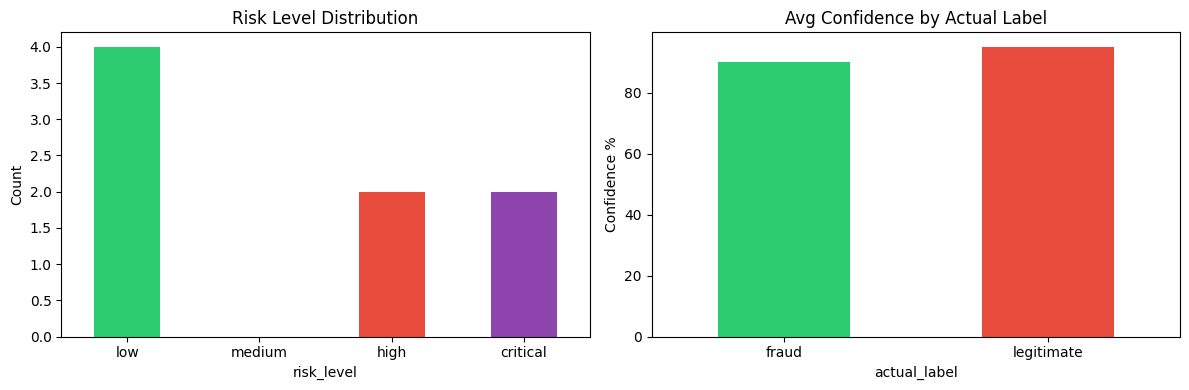


💡 The LLM correctly assigned higher risk to fraud transactions!
   And it did this with ZERO training — just a well-crafted prompt.


In [25]:
# =============================================================================
# DEMO: Batch Extraction Across All Transactions
# =============================================================================
# Run the structured extraction on all 8 transactions and visualize results.

client = OpenAI()

system_prompt = """You are a fraud analyst. Analyze transactions and return JSON:
{
    "risk_level": "low|medium|high|critical",
    "red_flags": ["list"],
    "recommended_action": "approve|review|block|escalate",
    "confidence": 0-100
}
Return ONLY valid JSON."""

all_signals = []

print("Extracting fraud signals from all transactions...")
for txn in transaction_descriptions:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Analyze:\n\n{txn['description']}"}
        ],
        temperature=0.0,
        max_tokens=200,
        response_format={"type": "json_object"}
    )
    signals = json.loads(response.choices[0].message.content)
    signals['id'] = txn['id']
    signals['actual_label'] = txn['actual_label']
    all_signals.append(signals)
    time.sleep(0.3)
    print(f"  ✓ {txn['id']}: {signals['risk_level']} ({signals['confidence']}%)")

# Create DataFrame and display
signals_df = pd.DataFrame(all_signals)[
    ['id', 'actual_label', 'risk_level', 'recommended_action', 'confidence']
]
print(f"\n{'='*60}")
display(signals_df)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Risk level distribution
risk_order = ['low', 'medium', 'high', 'critical']
risk_counts = signals_df['risk_level'].value_counts().reindex(risk_order, fill_value=0)
colors = {'low': '#2ecc71', 'medium': '#f39c12', 'high': '#e74c3c', 'critical': '#8e44ad'}
risk_counts.plot(kind='bar', ax=axes[0], color=[colors.get(r, 'gray') for r in risk_counts.index])
axes[0].set_title('Risk Level Distribution')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Confidence by actual label
signals_df.groupby('actual_label')['confidence'].mean().plot(
    kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c']
)
axes[1].set_title('Avg Confidence by Actual Label')
axes[1].set_ylabel('Confidence %')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n💡 The LLM correctly assigned higher risk to fraud transactions!")
print("   And it did this with ZERO training — just a well-crafted prompt.")

In [26]:
# =============================================================================
#LAB: Extract Structured Fraud Signals as JSON
# =============================================================================
# Instead of just "fraud/legitimate", we ask for a complete risk assessment.
# OpenAI supports response_format={"type": "json_object"} to enforce valid JSON.
# =============================================================================
# LAB 1: CLASSIFY TRANSACTIONS WITH OPENAI & ANTHROPIC
# =============================================================================

# Few-shot examples to include in your prompts
FEW_SHOT_EXAMPLES = """
Example 1:
Transaction: "You won million dollars click here"
Classification: spam

Example 2:
Transaction: "Your account is locked click here"
Classification: spam

Example 3:
Transaction: "You subscribed to newsletter"
Classification: not spam
"""

def classify_with_openai(description):
    """
    Classify a single transaction description using OpenAI GPT-4o-mini
    with few-shot prompting. Returns 'spam' or 'not spam'.
    """
    client = OpenAI()

    # Build the prompt using FEW_SHOT_EXAMPLES + the transaction description
    user_prompt = f"""{FEW_SHOT_EXAMPLES}
Now classify this transaction (respond with ONLY 'spam' or 'not spam'):
Transaction: "{description}"
Classification:"""

    # YOUR CODE: Create the chat completion request
    response = client.chat.completions.create(
         model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are an expert at identifying spam"},
        {"role": "user", "content": user_prompt}
    ],
    max_tokens=5
    )

    # YOUR CODE: Extract and clean the prediction text
    prediction = response.choices[0].message.content.strip()  # YOUR CODE

    return prediction


# =============================================================================
# RUN CLASSIFICATION ON ALL TRANSACTIONS
# =============================================================================
results = []

for txn in transaction_descriptions:
    print(f"Classifying {txn['id']}...")

    # YOUR CODE: Call both classifiers
    openai_pred = classify_with_openai(txn["description"])  # YOUR CODE
    time.sleep(0.5)  # Rate limiting


    results.append({
        'id': txn['id'],
        'actual_label': txn['actual_label'],
        'openai_prediction': openai_pred
    })

# YOUR CODE: Create DataFrame
results_df = pd.DataFrame(results)  # YOUR CODE

# YOUR CODE: Calculate accuracy for each provider
openai_accuracy = (results_df["actual_label"]==results_df["openai_prediction"]).mean() # YOUR CODE


# Verification
if results_df is not None:
    print(f"\n✅ Classification complete!")
    display(results_df)
    print(f"\nOpenAI Accuracy:    {openai_accuracy:.1%}")
else:
    print("❌ Lab 1 incomplete — fill in the YOUR CODE sections above")



Classifying TXN-001...
Classifying TXN-002...
Classifying TXN-003...
Classifying TXN-004...
Classifying TXN-005...
Classifying TXN-006...
Classifying TXN-007...
Classifying TXN-008...

✅ Classification complete!


,id,actual_label,openai_prediction
0,TXN-001,fraud,not spam
1,TXN-002,legitimate,not spam
2,TXN-003,fraud,not spam
3,TXN-004,legitimate,not spam
4,TXN-005,fraud,not spam
5,TXN-006,legitimate,not spam
6,TXN-007,fraud,spam
7,TXN-008,legitimate,not spam



OpenAI Accuracy:    0.0%


## 💬 Discussion 4: LLMs in Production Pipelines (3-5 minutes)

Looking at the structured extraction results above:

1. **The LLM effectively replaced Comprehend + feature engineering + XGBoost** with a
   single API call. Is this always better? What are the risks of replacing a trained,
   validated model with prompt-based classification?

2. **Consistency**: If you run the extraction twice, do you get the exact same confidence
   scores? What does this mean for reproducibility and regression testing?

3. **Cost at scale**: Our fraud pipeline processes thousands of transactions daily.
   At ~500 tokens/call and $0.15/million input tokens (GPT-4o-mini), what's the daily
   cost for 10,000 transactions? At what volume does it make sense to train a custom model?

4. **The "black box" problem**: XGBoost gives feature importance scores. An LLM gives
   reasoning text. Which is more trustworthy for regulatory compliance? Which is more
   useful for a human fraud analyst reviewing the case?

# Section 3: Local Text Generation with HuggingFace

Cloud APIs are powerful, but they have tradeoffs: cost per call, data leaves your
infrastructure, and you depend on an external service. **HuggingFace Transformers**
gives you direct access to open-source models you can run locally.

## Key HuggingFace Concepts

| Concept | What It Does | Example |
|---------|-------------|--------|
| **AutoTokenizer** | Converts text ↔ token IDs | `AutoTokenizer.from_pretrained("gpt2")` |
| **pipeline()** | Easiest way to run a model | `pipeline("text-generation", model="gpt2")` |
| **AutoModelForSeq2SeqLM** | Encoder-decoder models | Flan-T5 (follows instructions) |

## Why Learn This?

Even if you mostly use cloud APIs, HuggingFace is essential for:
- **Fine-tuning** models on your own data (coming in Week 14)
- **Running models locally** — your data never leaves your machine
- **Evaluating open-source alternatives** to paid APIs
- **Understanding tokenization** — the foundation of all LLM interaction and costs

In [ ]:
# =============================================================================
# DEMO: HuggingFace Pipeline — The Easiest Way to Generate Text
# =============================================================================
# The pipeline() API wraps tokenization + model + decoding in one call.
# It works the same way for ANY text generation model.

generator = pipeline(
    "text-generation",
    model="gpt2",      # 124M parameters — small but instructive
    device=-1           # -1 = CPU, 0 = first GPU
)

# Generate text continuation
prompt = "The fraud analyst reviewed the transaction and determined that"

outputs = generator(
    prompt,
    max_new_tokens=50,       # Generate up to 50 new tokens
    temperature=0.7,         # Some creativity
    do_sample=True,          # Enable sampling (not greedy)
    num_return_sequences=2   # Generate 2 different completions
)

print(f"Prompt: '{prompt}'\n")
for i, output in enumerate(outputs):
    print(f"Completion {i+1}:")
    print(f"  {output['generated_text']}")
    print()

print("💡 GPT-2 is small (124M params) — quality is limited!")
print("   But the pipeline API works identically for larger models.")
print("   Swap 'gpt2' for 'meta-llama/Llama-3-8B' and you get much better output.")

In [ ]:
# =============================================================================
# DEMO: Flan-T5 — A Model That Follows Instructions
# =============================================================================
# Flan-T5 is an encoder-decoder model fine-tuned on 1,000+ tasks.
# Unlike GPT-2 (which just continues text), Flan-T5 understands
# task prompts like "classify", "summarize", "translate".

flan_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
flan_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")


def generate_with_flan(prompt, max_new_tokens=100):
    """Generate a response from Flan-T5 given a task prompt."""
    inputs = flan_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = flan_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False  # Greedy decoding — deterministic output
    )
    return flan_tokenizer.decode(outputs[0], skip_special_tokens=True)


# === Test 1: Zero-shot classification ===
result = generate_with_flan(
    "Classify the following as fraud or legitimate: "
    "'Three ATM withdrawals in different cities within one hour'"
)
print(f"Zero-shot classification: {result}")

# === Test 2: One-shot classification ===
result = generate_with_flan(
    """Classify the transaction:

Example:
Transaction: "Monthly Netflix payment of $15.99"
Classification: legitimate

Transaction: "Five purchases at gas stations across 3 states in one hour"
Classification:"""
)
print(f"One-shot classification:  {result}")

# === Test 3: Sentiment analysis ===
result = generate_with_flan(
    "What is the sentiment of: "
    "'I am extremely upset about the unauthorized charges on my account'"
)
print(f"Sentiment analysis:      {result}")

print(f"\n💡 Flan-T5 understands task instructions!")
print(f"   But it's 250M params vs GPT-4's ~1 trillion — quality reflects that.")
print(f"   Great for learning the API; use larger models for production.")

## 💬 Discussion 5: Cloud vs Local Models (3-5 minutes)

You've now seen both cloud APIs and local HuggingFace models in action. Discuss:

1. **Quality gap**: GPT-4o-mini and Claude Haiku gave excellent fraud classifications.
   Flan-T5 gave reasonable but less nuanced results. When is "good enough" actually
   good enough? What accuracy threshold would a fraud team accept?

2. **Data sovereignty**: Financial regulations (GDPR, SOX, PCI-DSS) may restrict where
   customer data can be sent. How does this affect your choice of cloud vs local?
   Can you use cloud APIs if you anonymize the data first?

3. **Latency and throughput**: Cloud APIs have ~500ms network latency. Local models have
   load time but sub-100ms inference. Which matters more for real-time fraud detection
   vs nightly batch processing?

4. **Open source risk and reward**: HuggingFace models are community-maintained. What
   are the risks of using an open-source model in production (license changes,
   vulnerabilities, quality regression)? How do you vet a model before deploying it?

## Lab 2: Prompting Workshop with HuggingFace (15 minutes)

### Your Task

Compare **zero-shot, one-shot, and few-shot prompting** with Flan-T5 on our
fraud classification task. See how adding examples affects a smaller model.

### Steps

1. Write three prompt templates (zero-shot, one-shot, few-shot with 3 examples)
2. Run each strategy on 4 test transactions (TXN-001, TXN-003, TXN-005, TXN-007)
3. Record predictions and calculate accuracy per strategy
4. Observe: How does adding examples change the results?

### Expected Output

A DataFrame comparing predictions across strategies, plus accuracy per strategy.

### Hints

- Use the `generate_with_flan()` function from the demo above
- Keep prompts under 512 tokens (Flan-T5-base context limit)
- Normalize responses: `.strip().lower()` — model may return 'Fraud' vs 'fraud'
- Use DIFFERENT examples than the test transactions!

### 📝 Homework Extension

After class: repeat this experiment using **OpenAI or Anthropic** instead of Flan-T5.
How do prompting techniques compare across model sizes? Also try writing a
chain-of-thought prompt for Flan-T5 — can a smaller model reason step by step?

In [ ]:
# =============================================================================
# LAB 2: PROMPTING WORKSHOP WITH HUGGINGFACE
# =============================================================================

# Test on 4 transactions (mix of fraud and legitimate)
test_transactions = [transaction_descriptions[i] for i in [0, 2, 4, 6]]


def classify_zero_shot(description):
    """Zero-shot classification with Flan-T5 — instructions only, no examples."""
    # YOUR CODE: Create a zero-shot prompt for fraud classification
    prompt = None  # YOUR CODE

    result = None  # YOUR CODE
    return result


def classify_one_shot(description):
    """One-shot classification with Flan-T5 — one example provided."""
    # YOUR CODE: Create a one-shot prompt with 1 example + the transaction
    prompt = None  # YOUR CODE

    result = None  # YOUR CODE
    return result


def classify_few_shot(description):
    """Few-shot classification with Flan-T5 — three examples provided."""
    # YOUR CODE: Create a few-shot prompt with 3 examples + the transaction
    # Use different examples than the test transactions!
    prompt = None  # YOUR CODE

    result = None  # YOUR CODE
    return result


# =============================================================================
# RUN ALL STRATEGIES
# =============================================================================
strategies = {
    'zero_shot': classify_zero_shot,
    'one_shot': classify_one_shot,
    'few_shot': classify_few_shot
}

lab2_results = []

for txn in test_transactions:
    row = {'id': txn['id'], 'actual': txn['actual_label']}

    for strategy_name, classify_fn in strategies.items():
        # YOUR CODE: Call the classification function
        prediction = None  # YOUR CODE
        row[strategy_name] = prediction

    lab2_results.append(row)
    print(f"Classified {txn['id']}: {row}")

# YOUR CODE: Create DataFrame and calculate accuracy for each strategy
lab2_df = None  # YOUR CODE

zero_shot_acc = None  # YOUR CODE
one_shot_acc = None   # YOUR CODE
few_shot_acc = None   # YOUR CODE

# Verification
if lab2_df is not None:
    print(f"\n✅ Prompting Workshop Results:")
    display(lab2_df)
    print(f"\nAccuracy by Strategy:")
    print(f"  Zero-shot: {zero_shot_acc:.1%}")
    print(f"  One-shot:  {one_shot_acc:.1%}")
    print(f"  Few-shot:  {few_shot_acc:.1%}")
    print(f"\n💡 How did adding examples affect the smaller model?")
else:
    print("❌ Lab 2 incomplete — fill in the YOUR CODE sections above")

# Summary: What We Learned Today

## Key Takeaways

### LLMs vs Traditional ML
- LLMs perform classification, extraction, and analysis with **natural language prompts**
- No model training needed — but tradeoffs in cost, consistency, and control
- Traditional ML (XGBoost) gives reproducibility and feature importance
- LLMs give flexibility, natural language reasoning, and structured extraction

### Cloud APIs (OpenAI & Anthropic)
| | OpenAI | Anthropic |
|---|--------|----------|
| **Create request** | `client.chat.completions.create()` | `client.messages.create()` |
| **Get response** | `response.choices[0].message.content` | `message.content[0].text` |
| **System prompt** | Inside `messages` list | Separate `system` parameter |
| **Model used** | `gpt-4o-mini` | `claude-haiku-4-5-20251001` |

### Prompting Techniques
| Technique | Best For | Tradeoff |
|-----------|----------|----------|
| **Zero-shot** | Simple, clear tasks | Fast & cheap, less consistent |
| **Few-shot** | Consistent formatting | Better results, costs more tokens |
| **Chain-of-thought** | Complex reasoning & auditing | Best analysis, most expensive |

### HuggingFace
- Run models locally — data never leaves your machine
- `pipeline()` is the easiest entry point for any task
- Flan-T5 follows instructions; GPT-2 does text completion
- Smaller models = less capable but free, private, and fast

## The Bigger Picture

| Week | Approach | Tool |
|------|----------|------|
| 5-6 | Pre-trained NLP services | Amazon Comprehend |
| 6 | Traditional ML | SageMaker XGBoost |
| **11** | **LLM prompting** | **OpenAI, Anthropic, HuggingFace** |
| 12+ | GenAI applications | Building on today's foundations |

# Homework & Optional Labs

## 📝 Homework (Complete before next session)

### Homework 1: Structured Extraction with Anthropic
Using the JSON extraction demo (Section 2.4: Structured Data Extraction) as a
template, write a function that extracts fraud signals from all 8 transactions
using **Anthropic Claude** instead of OpenAI. Compare the JSON outputs:
- Do the providers flag the same red flags?
- Are confidence scores similar?
- Which gives more actionable reasoning?

### Homework 2: Prompt Optimization Journey
Start with a basic zero-shot prompt and iteratively improve it through 4 stages:
1. Zero-shot (baseline accuracy)
2. Add few-shot examples (measure accuracy change)
3. Add chain-of-thought instructions (measure accuracy change)
4. Add output format constraints (measure accuracy change)

Create a table showing accuracy at each stage. Write 2-3 sentences about what
you learned about prompt design.

## 🔬 Optional Labs (For advanced learners)

### Optional Lab 1: Temperature Exploration
Run the same classification prompt 5 times each at temperatures 0.0, 0.3, 0.7, 1.0.
Plot the variance in results across runs. What does this tell you about choosing
temperature settings for production fraud detection?

### Optional Lab 2: Model Comparison Dashboard
Classify all 8 transactions with GPT-4o-mini, Claude Haiku, and Flan-T5.
Create a comparison table: accuracy, average response time, estimated cost per call.
Which model offers the best value for this task?

### Optional Lab 3: Streaming Responses
Implement streaming for both OpenAI and Anthropic APIs to see responses generated
token by token. Use `stream=True` parameter and iterate over chunks.

## 🔬 Deep Dive: Attention & Transformers

For hands-on exploration of how attention works, multi-head attention in PyTorch,
and building a transformer encoder layer from scratch, see:

📓 **`week_11_optional_attention_transformers.ipynb`**

# Great Work Today!

You've taken the first step into the GenAI world:

✅ Understood what LLMs are and why they matter for data science
✅ Called OpenAI and Anthropic APIs for fraud detection tasks
✅ Applied zero-shot, few-shot, and chain-of-thought prompting
✅ Extracted structured JSON data from unstructured text
✅ Used HuggingFace Flan-T5 for local text generation
✅ Discussed real-world implications: cost, privacy, reproducibility, regulation

## Coming Up Next

- **Week 12**: GenAI for Data Science — synthetic data, LLM-assisted analysis, BLEU/ROUGE
- **Week 13**: Amazon Bedrock — managed model access and deployment
- **Week 14**: Training AI Models — fine-tuning with LoRA and QLoRA
- **Weeks 15-16**: Agentic AI — ReAct agents, LangChain, multi-agent systems
- **Weeks 17-18**: RAG (Retrieval-Augmented Generation) — retrieval, chunking, evaluation

## Resources

- [OpenAI API Documentation](https://platform.openai.com/docs/)
- [Anthropic API Documentation](https://docs.anthropic.com/)
- [HuggingFace Transformers Docs](https://huggingface.co/docs/transformers/)
- [Tokenizer Visualizer](https://tiktokenizer.vercel.app/) — see how any text is tokenized
- [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) — visual guide

See you in Week 12!